In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from scipy import signal
from scipy.fftpack import fft

import torch
import torch.nn as nn
import torch.nn.functional as f

import fastai2 
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

print("Pytorch:", torch.__version__)
print("Fastai2:", fastai2.__version__)

Pytorch: 1.5.0
Fastai2: 0.0.17


In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #tf.random.set_seed(seed) # Tensorflow

# Data

In [3]:
train = pd.DataFrame({"x": np.load('data/0_x_train.npy'),
                      "g": np.load("data/0_groups_train.npy"),
                      "y": np.load('data/0_y_train.npy')})
                      
test  = pd.DataFrame({"x": np.load('data/0_x_test.npy'),
                      "g": np.load("data/0_groups_test.npy"),
                      "y": np.load('data/0_x_test.npy')}) # CHAPUZA para ahorrar codigo

In [4]:
train0 = train[      0: 500000]
train1 = train[ 500000:1000000]
train2 = train[1000000:1500000]
train3 = train[1500000:2000000]
train4 = train[2000000:2500000]
train5 = train[2500000:3000000]
train6 = train[3000000:3500000]
train7 = train[3500000:4000000]
train8 = train[4000000:4500000]
train9 = train[4500000:5000000]

In [5]:
test.head(2)

,x,g,y
0,-2.649800,0,-2.649800
1,-2.849432,0,-2.849432


# DataLoader

In [6]:
# TODO: Add data batch id
# TODO: 2D fetaures (scalogram...)

class DS(torch.utils.data.Dataset):
    def __init__(self, df):
        self.array_x   = df["x"].values
        self.array_g   = df["g"].values
        self.array_y   = df["y"].values
        
    def __len__(self):
        return len(self.array_x)
    
    def __getitem__(self, i):
        value    = torch.tensor(self.array_x[i]).unsqueeze(0)
        group    = torch.tensor(self.array_g[i],  dtype=torch.int64)
        group_oh = F.one_hot(group, num_classes=5).float()
        
        x = torch.cat([value, group_oh])
        y = torch.tensor(self.array_y[i], dtype=torch.long)
        return (x, y)

In [7]:
m = 10000
#toy_train = DS(pd.concat([train0[:m], train2[:m], train7[:m], train5[:m], train4[:m]]))
#toy_valid = DS(pd.concat([train1[:m], train6[:m], train3[:m], train8[:m], train9[:m]]))

half_train = DS(pd.concat([train0, train2, train7, train5, train9]))
half_valid = DS(pd.concat([train1, train6, train3, train8, train4]))
all_train  = DS(train)

test_ds  = DS(test)

In [8]:
BS = 512#256

dls_half = DataLoaders.from_dsets(half_train,  half_valid,  test_ds, bs=1024)#, device=torch.device("cuda"))
dls_all  = DataLoaders.from_dsets(all_train,   all_train,   test_ds, bs=1024, device=torch.device("cuda"))

# Model

In [9]:
# TODO: ReLU , BatchNorm, Dropout

class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.li = nn.Linear(in_features=6,  out_features=11)
        
    def forward(self, x): # ENTRADA 6: value=1 + onehot=5
        return self.li(x)
            
linear = Linear()

In [10]:
linear(torch.randn(6)).shape

torch.Size([11])

# Train

In [11]:
# TODO: Weighted by class
# TODO: Better loss for F1 macro??? Focal??
# TODO: Adam, Radam,...
learn = Learner(dls       = dls_all, #dls_half, dls_all
                model     = linear,
                loss_func = nn.CrossEntropyLoss(weight=None), # F.cross_entropy, CrossEntropyLossFlat(),
                metrics   = [F1Score(average='macro'), accuracy],
                cbs       = ShowGraphCallback())
#learn.summary()

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.25118863582611084)

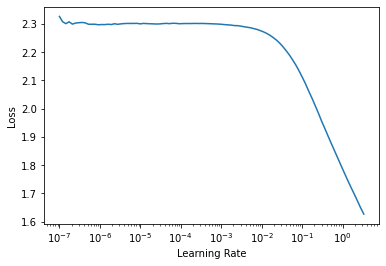

In [12]:
learn.lr_find()

In [13]:
10e-1

1.0

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.243559,0.238393,0.917232,0.956451,04:46


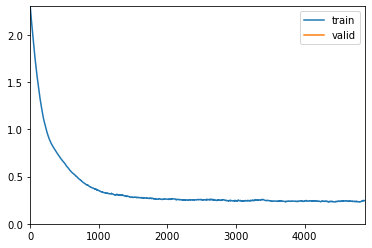

In [13]:
learn.fit_one_cycle(n_epoch=1, lr_max=0.1)

# Validación

In [14]:
preds,targs = learn.get_preds()

preds = torch.max(preds, 1)[1].numpy()
len(preds)

5000000

In [15]:
np.save('data/1_linear_preds_train.npy', preds)

# Test

In [16]:
preds_t,targs_t = learn.get_preds(ds_idx=2)

preds_t = torch.max(preds_t, 1)[1].numpy()
len(preds_t)

<ipython-input-6-82dd54d71f20>:19: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.array_y[i], dtype=torch.long)


2000000

In [17]:
np.save('data/1_linear_preds_test.npy', preds_t)

In [18]:
len(preds_t)

2000000

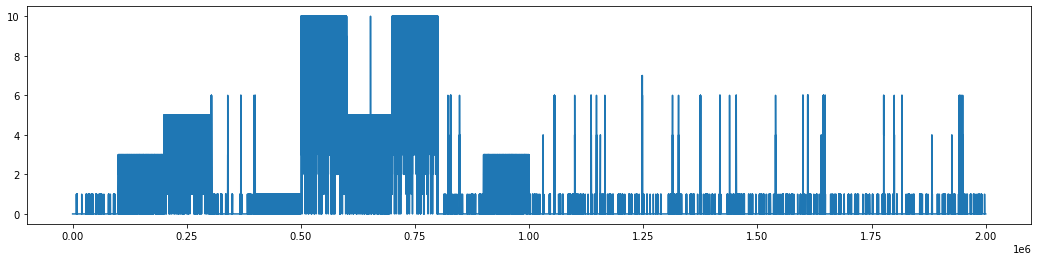

In [19]:
plt.figure(figsize=(18, 4))
plt.plot(preds_t);

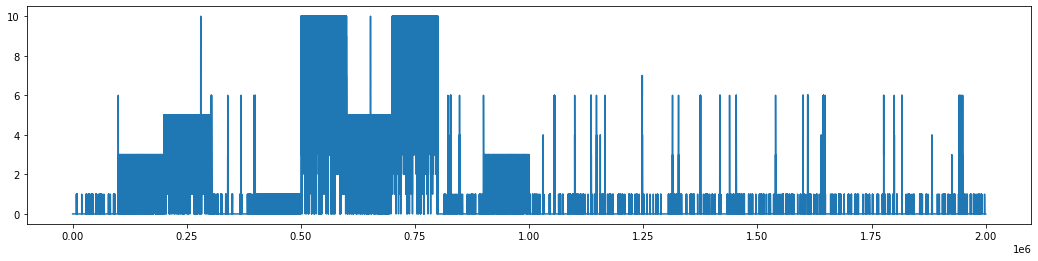

In [20]:
plt.figure(figsize=(18, 4))
plt.plot(preds_t);

# <center> FIN